In [ ]:
# Input data

import scipy.io as spio
import numpy as np

new_imagery = spio.loadmat(file_name='../data/bci_EEG_data-new/new_imagery.mat')
new_imagery_data = new_imagery['new_imagery']
print(new_imagery_data.shape, new_imagery_data.dtype)

new_imagery_data_transposed = new_imagery_data.transpose(2, 0, 1)
print(new_imagery_data_transposed.shape)

# Deviding the input data into train and validation
# For creating the training and testing set, 30% percent of each subject is considered as test and
# 70% of each subject is conidered as training.
length = int(new_imagery_data_transposed.shape[0] * 0.30)
# length

train_data_all = new_imagery_data_transposed[:-length]
test_data = new_imagery_data_transposed[-length:]

print(new_imagery_data_transposed.shape, new_imagery_data_transposed.dtype, 
 train_data_all.shape, train_data_all.dtype, 
 test_data.shape, test_data.dtype)

# 30% of the total training data is validation,
# 70% of the total training data is training
# This is applied to every single subject data.
length2 = int(train_data_all.shape[0] * 0.30)
# length2

train_data = train_data_all[:-length2]
valid_data = train_data_all[-length2:]

print(train_data_all.shape, train_data_all.dtype, 
 train_data.shape, train_data.dtype, 
 valid_data.shape, valid_data.dtype)

In [ ]:
new_imagery_label = spio.loadmat(file_name='../data/bci_EEG_data-new/new_imagery_label.mat')
# print(new_imagery_label.keys())
new_imagery_label_all = new_imagery_label['new_imagery_label']
print(new_imagery_label_all.shape, new_imagery_label_all.dtype)
print(new_imagery_label_all.max(axis=0)+1)

label_train_all = new_imagery_label_all[:-length]
label_test = new_imagery_label_all[-length:]

print(new_imagery_label_all.shape, new_imagery_label_all.dtype,
 label_test.shape, label_test.dtype, 
 label_train_all.shape, label_train_all.dtype)

label_train = label_train_all[:-length2]
label_valid = label_train_all[-length2:]
print(label_train.shape, label_valid.shape)

In [ ]:
# # Normalizing input data
# def normalize(inputs, inputs_all):
#     return (inputs - inputs_all.mean(axis=0)[None,:,:]) / inputs_all.std(axis=0)[None,:,:]
# Yalda suggested this normalization.
def normalize(inputs):
    return (inputs - inputs.mean(axis=0)[None,:,:]) / inputs.std(axis=0)[None,:,:]

# onehot vectorizing output labels
def one_hot(labels, n_class):
    """ One-hot encoding """
    expansion = np.eye(n_class)
    y = expansion[:, labels-1].T
    assert y.shape[1] == n_class, "Wrong number of labels!"

    return y

# get minibatches for learning
def get_batches(X, y, batch_size):
    """ Return a generator for batches """
    n_batches = len(X) // batch_size
    X, y = X[:n_batches*batch_size], y[:n_batches*batch_size]

    # Loop over batches and yield
    for b in range(0, len(X), batch_size):
        yield X[b:b+batch_size], y[b:b+batch_size]

# Standardize/normalize train and test
# X_train_norm_all = normalize(inputs=FacesDataTrain, inputs_all=FacesDataAll)
X_train_norm = normalize(inputs=train_data)
X_valid_norm = normalize(inputs=valid_data)
X_test_norm = normalize(inputs=test_data)

print(X_train_norm.shape, X_train_norm.dtype, 
X_valid_norm.shape, X_valid_norm.dtype,
X_test_norm.shape, X_test_norm.dtype)

In [ ]:
### Hyperparameters

# Input data
batch_size = X_train_norm.shape[0]// 100 # minibatch size & number of minibatches
seq_len = X_train_norm.shape[1] # Number of steps: each trial length
n_channels = X_train_norm.shape[2] # number of channels in each trial
print('batch_size, seq_len, n_channels', batch_size, seq_len, n_channels)

# Output labels
n_classes = int(new_imagery_label_all.max(axis=0) + 1)
print('n_classes', n_classes)

# Tweekable parameters
learning_rate = 0.001 #1e-3
epochs = 100 # num iterations for updating model
keep_prob = 0.50 # 90% neurons are kept and 10% are dropped out

In [ ]:
Y_train = np.array(label_train, dtype=int).reshape(-1)
Y_valid = np.array(label_valid, dtype=int).reshape(-1)
Y_test = np.array(label_test, dtype=int).reshape(-1)

Y_train_onehot = one_hot(labels=Y_train, n_class=n_classes)
Y_valid_onehot = one_hot(labels=Y_valid, n_class=n_classes)
Y_test_onehot = one_hot(labels=Y_test, n_class=n_classes)

print(Y_train_onehot.shape, Y_valid_onehot.shape, Y_test_onehot.shape, 
 X_train_norm.shape, X_valid_norm.shape, X_test_norm.shape)

print(Y_train_onehot.dtype, Y_valid_onehot.dtype, Y_test_onehot.dtype,
 X_train_norm.dtype, X_valid_norm.dtype, X_test_norm.dtype)

In [ ]:
# GPUs or CPU

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

#  No graphs is needed on tensorflow
inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs_')
labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels_')
keep_prob_ = tf.placeholder(tf.float32, name = 'keep_prob_')
learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate_')# Construct the LSTM inputs and LSTM cells

In [ ]:
# Forward pass: Convolutional Layers, FC Layer, and Output layer
# batch_size, seq_len, n_channels: 6, 3584, 13
# (batch, 3584, 13) --> (batch, 1790, 26)
# (3584 - 6 + 0)/2 + 1 = (3578/2)+1= 1789 +1 = 1790
# 2/6 with strides/kernel_size is 
# 33.333% non-overlap/diff region and 
# 66.666% overlapping window/ common region
in_conv = inputs_
out_conv = tf.layers.conv1d(inputs=in_conv, filters=26, kernel_size=6, strides=2, padding='valid')
out_conv = tf.layers.batch_normalization(inputs=out_conv)
out_conv = tf.nn.relu(features=out_conv)
out_conv = tf.nn.dropout(x=out_conv, keep_prob=keep_prob_)
print(in_conv.shape, out_conv.shape)

# To reduce the size for memory efficiency & equivariancy/invariency/ minicolumns
# (batch, 1790, 26) --> (batch, 446, 26)
# (1790 - 10 + 0)/4 + 1 = (1780/4)+1= 445 +1 = 446
# 4/10 with strides/kernel_size is 
# 40% non-overlap/diff region and 
# 60% overlapping window/ common region
in_pool = out_conv
out_pool = tf.layers.max_pooling1d(inputs=in_pool, pool_size=10, strides=4, padding='valid')
print(in_pool.shape, out_pool.shape)

# (batch, 446, 26) --> (batch, 221, 52)
# (446 - 6 + 0)/2 + 1 = (440/2)+1= 220+1= 221
# 2/6 with strides/kernel_size is 
# 33.33% non-overlap/diff region and 
# 66.66% overlapping window/ common region
in_conv = out_pool
out_conv = tf.layers.conv1d(inputs=in_conv, filters=52, kernel_size=6, strides=2, padding='valid')
out_conv = tf.layers.batch_normalization(inputs=out_conv)
out_conv = tf.nn.relu(features=out_conv)
out_conv = tf.nn.dropout(x=out_conv, keep_prob=keep_prob_)
print(in_conv.shape, out_conv.shape)

# To reduce the size for memory efficiency & equivariancy/invariency/ minicolumns
# (batch, 221, 52) --> (batch, 43, 52)
# (221 - 11 + 0)/5 + 1 = (210/5)+1= 42 +1 = 43
# 5/11 with strides/kernel_size is 
# ~45.5% non-overlap/diff region and 
# ~64.5% overlapping window/ common region
in_pool = out_conv
out_pool = tf.layers.max_pooling1d(inputs=in_pool, pool_size=11, strides=5, padding='valid')
print(in_pool.shape, out_pool.shape)

# (batch, 43, 52) --> (batch, 43*52) --> (batch, 43*52*2)
in_fc = tf.reshape(tensor=out_pool, shape=(-1, 43*52))
out_fc = tf.layers.dense(inputs=in_fc, units=43*52*2)
out_fc = tf.layers.batch_normalization(inputs=out_fc)
out_fc = tf.nn.relu(features=out_fc)
out_fc = tf.nn.dropout(x=out_fc, keep_prob=keep_prob_)
print(out_pool.shape, in_fc.shape, out_fc.shape)

# (batch, 43*52*2) --> (batch, 4) 
logits = tf.layers.dense(inputs=out_fc, units=n_classes)
print(out_fc.shape, logits.shape)

In [17]:
# Backward pass: error backpropagation
# Cost function
cost_tensor = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_)
cost = tf.reduce_mean(input_tensor=cost_tensor)

# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate_).minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

In [4]:
# Train the network
# Plotting the acc and loss curve
train_acc = []
train_loss = []

valid_acc = []
valid_loss = []

with tf.Session() as sess:
    # initalize session global variables just in the case they are initialized.
    sess.run(tf.global_variables_initializer())
    
    for e in range(epochs):
       
        # Loop over batches
        for x, y in get_batches(X_train_norm, Y_train_onehot, batch_size):
            
            # Feed dictionary
            feed = {inputs_:x, labels_:y, keep_prob_: keep_prob, learning_rate_:learning_rate}
            loss, _ , acc = sess.run([cost, optimizer, accuracy], feed_dict = feed)
            
            train_acc.append(acc)
            train_loss.append(loss)
            
            ################################ Validation
            # Initialize 
            loss_v_batch, acc_v_batch = [], []

            # Loop over batches
            for x_v, y_v in get_batches(X_valid_norm, Y_valid_onehot, batch_size):

                # Feed dictionary
                feed = {inputs_:x_v, labels_:y_v, keep_prob_: 1.0}
                loss_v, acc_v = sess.run([cost, accuracy], feed_dict = feed)
                
                acc_v_batch.append(acc_v)
                loss_v_batch.append(loss_v)
                
            valid_acc.append(np.mean(acc_v_batch))
            valid_loss.append(np.mean(loss_v_batch))
            
            # Print info
            print("Epoch: {}/{}".format(e+1, epochs),
                  "Train loss: {:6f}".format(loss),
                  "Valid loss: {:.6f}".format(np.mean(valid_loss)),
                  "Train acc: {:6f}".format(acc),
                  "Valid acc: {:.6f}".format(np.mean(valid_acc)))
            
    ################################ Test
    # Initialize 
    acc_batch, loss_batch = [], []

    # Loop over batches
    for x, y in get_batches(X_test_norm, Y_test_onehot, batch_size):

        # Feed dictionary
        feed = {inputs_:x, labels_:y, keep_prob_:1.0}
        loss, acc = sess.run([cost, accuracy], feed_dict = feed)

        acc_batch.append(acc)
        loss_batch.append(loss)

    # Print info
    print("Epoch: {}/{}".format(e+1, epochs),
          "Test loss: {:6f}".format(np.mean(loss_batch)),
          "Test acc: {:6f}".format(np.mean(acc_batch)))

Epoch: 1/10 Train loss: 0.825126 Valid loss: 6.321150 Train acc: 0.389474 Valid acc: 0.833468
Epoch: 1/10 Train loss: 4.102737 Valid loss: 6.099168 Train acc: 0.842105 Valid acc: 0.833468
Epoch: 1/10 Train loss: 4.101676 Valid loss: 5.375078 Train acc: 0.831579 Valid acc: 0.833468
Epoch: 1/10 Train loss: 2.860102 Valid loss: 4.581524 Train acc: 0.831579 Valid acc: 0.833468
Epoch: 1/10 Train loss: 1.722166 Valid loss: 3.881145 Train acc: 0.831579 Valid acc: 0.833468
Epoch: 1/10 Train loss: 0.932480 Valid loss: 3.323048 Train acc: 0.831579 Valid acc: 0.833468
Epoch: 1/10 Train loss: 0.492617 Valid loss: 2.916594 Train acc: 0.831579 Valid acc: 0.833468
Epoch: 1/10 Train loss: 0.470911 Valid loss: 2.626531 Train acc: 0.831579 Valid acc: 0.833502
Epoch: 1/10 Train loss: 0.561634 Valid loss: 2.408175 Train acc: 0.831579 Valid acc: 0.829450
Epoch: 1/10 Train loss: 0.617193 Valid loss: 2.234608 Train acc: 0.821053 Valid acc: 0.821161
Epoch: 1/10 Train loss: 0.629621 Valid loss: 2.091463 Train 

Epoch: 1/10 Train loss: 0.953453 Valid loss: 0.659336 Train acc: 0.831579 Valid acc: 0.832125
Epoch: 1/10 Train loss: 0.612580 Valid loss: 0.657804 Train acc: 0.842105 Valid acc: 0.832218
Epoch: 1/10 Train loss: 0.462744 Valid loss: 0.656621 Train acc: 0.821053 Valid acc: 0.832350
Epoch: 1/10 Train loss: 0.497360 Valid loss: 0.655668 Train acc: 0.831579 Valid acc: 0.832503
Epoch: 1/10 Train loss: 0.518475 Valid loss: 0.654856 Train acc: 0.831579 Valid acc: 0.832667
Epoch: 1/10 Train loss: 0.502389 Valid loss: 0.654109 Train acc: 0.873684 Valid acc: 0.832814
Epoch: 1/10 Train loss: 0.534019 Valid loss: 0.653377 Train acc: 0.821053 Valid acc: 0.832957
Epoch: 1/10 Train loss: 0.526161 Valid loss: 0.652617 Train acc: 0.852632 Valid acc: 0.833064
Epoch: 1/10 Train loss: 0.526416 Valid loss: 0.651797 Train acc: 0.842105 Valid acc: 0.833132
Epoch: 1/10 Train loss: 0.506791 Valid loss: 0.650889 Train acc: 0.831579 Valid acc: 0.833182
Epoch: 1/10 Train loss: 0.490948 Valid loss: 0.649868 Train 

Epoch: 2/10 Train loss: 0.403026 Valid loss: 0.547887 Train acc: 0.831579 Valid acc: 0.838906
Epoch: 2/10 Train loss: 0.355610 Valid loss: 0.547124 Train acc: 0.842105 Valid acc: 0.838901
Epoch: 2/10 Train loss: 0.421498 Valid loss: 0.546351 Train acc: 0.810526 Valid acc: 0.838897
Epoch: 2/10 Train loss: 0.361830 Valid loss: 0.545561 Train acc: 0.852632 Valid acc: 0.838889
Epoch: 2/10 Train loss: 0.395953 Valid loss: 0.544760 Train acc: 0.831579 Valid acc: 0.838881
Epoch: 2/10 Train loss: 0.364935 Valid loss: 0.543951 Train acc: 0.831579 Valid acc: 0.838878
Epoch: 2/10 Train loss: 0.320782 Valid loss: 0.543135 Train acc: 0.831579 Valid acc: 0.838883
Epoch: 2/10 Train loss: 0.346359 Valid loss: 0.542317 Train acc: 0.831579 Valid acc: 0.838889
Epoch: 2/10 Train loss: 0.336717 Valid loss: 0.541496 Train acc: 0.831579 Valid acc: 0.838906
Epoch: 2/10 Train loss: 0.353726 Valid loss: 0.540674 Train acc: 0.831579 Valid acc: 0.838929
Epoch: 2/10 Train loss: 0.357590 Valid loss: 0.539852 Train 

Epoch: 3/10 Train loss: 0.586790 Valid loss: 0.491734 Train acc: 0.800000 Valid acc: 0.846373
Epoch: 3/10 Train loss: 0.481316 Valid loss: 0.491421 Train acc: 0.800000 Valid acc: 0.846438
Epoch: 3/10 Train loss: 0.495185 Valid loss: 0.491138 Train acc: 0.800000 Valid acc: 0.846496
Epoch: 3/10 Train loss: 0.510167 Valid loss: 0.490888 Train acc: 0.821053 Valid acc: 0.846544
Epoch: 3/10 Train loss: 0.349739 Valid loss: 0.490659 Train acc: 0.842105 Valid acc: 0.846588
Epoch: 3/10 Train loss: 0.419065 Valid loss: 0.490445 Train acc: 0.810526 Valid acc: 0.846618
Epoch: 3/10 Train loss: 0.403237 Valid loss: 0.490241 Train acc: 0.831579 Valid acc: 0.846642
Epoch: 3/10 Train loss: 0.442487 Valid loss: 0.490046 Train acc: 0.831579 Valid acc: 0.846659
Epoch: 3/10 Train loss: 0.372593 Valid loss: 0.489856 Train acc: 0.831579 Valid acc: 0.846669
Epoch: 3/10 Train loss: 0.377354 Valid loss: 0.489662 Train acc: 0.831579 Valid acc: 0.846670
Epoch: 3/10 Train loss: 0.332066 Valid loss: 0.489457 Train 

Epoch: 4/10 Train loss: 0.315235 Valid loss: 0.459750 Train acc: 0.873684 Valid acc: 0.851027
Epoch: 4/10 Train loss: 0.417262 Valid loss: 0.459536 Train acc: 0.810526 Valid acc: 0.851065
Epoch: 4/10 Train loss: 0.410094 Valid loss: 0.459316 Train acc: 0.842105 Valid acc: 0.851106
Epoch: 4/10 Train loss: 0.379292 Valid loss: 0.459090 Train acc: 0.810526 Valid acc: 0.851146
Epoch: 4/10 Train loss: 0.341425 Valid loss: 0.458856 Train acc: 0.842105 Valid acc: 0.851189
Epoch: 4/10 Train loss: 0.421616 Valid loss: 0.458623 Train acc: 0.810526 Valid acc: 0.851235
Epoch: 4/10 Train loss: 0.324791 Valid loss: 0.458385 Train acc: 0.852632 Valid acc: 0.851284
Epoch: 4/10 Train loss: 0.338179 Valid loss: 0.458144 Train acc: 0.852632 Valid acc: 0.851338
Epoch: 4/10 Train loss: 0.259403 Valid loss: 0.457893 Train acc: 0.873684 Valid acc: 0.851394
Epoch: 4/10 Train loss: 0.331915 Valid loss: 0.457635 Train acc: 0.831579 Valid acc: 0.851453
Epoch: 4/10 Train loss: 0.602940 Valid loss: 0.457381 Train 

Epoch: 5/10 Train loss: 0.328371 Valid loss: 0.438954 Train acc: 0.873684 Valid acc: 0.854382
Epoch: 5/10 Train loss: 0.423176 Valid loss: 0.438771 Train acc: 0.821053 Valid acc: 0.854387
Epoch: 5/10 Train loss: 0.366760 Valid loss: 0.438599 Train acc: 0.831579 Valid acc: 0.854391
Epoch: 5/10 Train loss: 0.389498 Valid loss: 0.438444 Train acc: 0.842105 Valid acc: 0.854396
Epoch: 5/10 Train loss: 0.435119 Valid loss: 0.438304 Train acc: 0.842105 Valid acc: 0.854401
Epoch: 5/10 Train loss: 0.349757 Valid loss: 0.438178 Train acc: 0.821053 Valid acc: 0.854410
Epoch: 5/10 Train loss: 0.222946 Valid loss: 0.438063 Train acc: 0.936842 Valid acc: 0.854421
Epoch: 5/10 Train loss: 0.298878 Valid loss: 0.437958 Train acc: 0.884211 Valid acc: 0.854432
Epoch: 5/10 Train loss: 0.373685 Valid loss: 0.437861 Train acc: 0.852632 Valid acc: 0.854446
Epoch: 5/10 Train loss: 0.307083 Valid loss: 0.437767 Train acc: 0.863158 Valid acc: 0.854462
Epoch: 5/10 Train loss: 0.382284 Valid loss: 0.437675 Train 

Epoch: 6/10 Train loss: 0.203688 Valid loss: 0.424652 Train acc: 0.915790 Valid acc: 0.857366
Epoch: 6/10 Train loss: 0.080997 Valid loss: 0.424420 Train acc: 0.989474 Valid acc: 0.857407
Epoch: 6/10 Train loss: 0.154180 Valid loss: 0.424200 Train acc: 0.947369 Valid acc: 0.857440
Epoch: 6/10 Train loss: 0.077385 Valid loss: 0.423991 Train acc: 0.968421 Valid acc: 0.857468
Epoch: 6/10 Train loss: 0.196666 Valid loss: 0.423790 Train acc: 0.947369 Valid acc: 0.857493
Epoch: 6/10 Train loss: 0.176937 Valid loss: 0.423594 Train acc: 0.936842 Valid acc: 0.857516
Epoch: 6/10 Train loss: 0.124680 Valid loss: 0.423402 Train acc: 0.947369 Valid acc: 0.857540
Epoch: 6/10 Train loss: 0.121585 Valid loss: 0.423212 Train acc: 0.968421 Valid acc: 0.857560
Epoch: 6/10 Train loss: 0.097635 Valid loss: 0.423023 Train acc: 0.968421 Valid acc: 0.857578
Epoch: 6/10 Train loss: 0.143584 Valid loss: 0.422836 Train acc: 0.947369 Valid acc: 0.857594
Epoch: 6/10 Train loss: 0.393614 Valid loss: 0.422651 Train 

Epoch: 7/10 Train loss: 0.253211 Valid loss: 0.412591 Train acc: 0.894737 Valid acc: 0.859620
Epoch: 7/10 Train loss: 0.183862 Valid loss: 0.412414 Train acc: 0.905263 Valid acc: 0.859633
Epoch: 7/10 Train loss: 0.172122 Valid loss: 0.412222 Train acc: 0.936842 Valid acc: 0.859655
Epoch: 7/10 Train loss: 0.220074 Valid loss: 0.412014 Train acc: 0.905263 Valid acc: 0.859690
Epoch: 7/10 Train loss: 0.072989 Valid loss: 0.411796 Train acc: 0.978947 Valid acc: 0.859734
Epoch: 7/10 Train loss: 0.159673 Valid loss: 0.411577 Train acc: 0.905263 Valid acc: 0.859780
Epoch: 7/10 Train loss: 0.230281 Valid loss: 0.411363 Train acc: 0.915790 Valid acc: 0.859823
Epoch: 7/10 Train loss: 0.126621 Valid loss: 0.411164 Train acc: 0.936842 Valid acc: 0.859857
Epoch: 7/10 Train loss: 0.178587 Valid loss: 0.410982 Train acc: 0.936842 Valid acc: 0.859880
Epoch: 7/10 Train loss: 0.080349 Valid loss: 0.410815 Train acc: 0.947369 Valid acc: 0.859898
Epoch: 7/10 Train loss: 0.491219 Valid loss: 0.410649 Train 

Epoch: 8/10 Train loss: 0.372214 Valid loss: 0.402364 Train acc: 0.831579 Valid acc: 0.861583
Epoch: 8/10 Train loss: 0.264061 Valid loss: 0.402207 Train acc: 0.915789 Valid acc: 0.861607
Epoch: 8/10 Train loss: 0.179267 Valid loss: 0.402053 Train acc: 0.947369 Valid acc: 0.861629
Epoch: 8/10 Train loss: 0.209518 Valid loss: 0.401901 Train acc: 0.926316 Valid acc: 0.861645
Epoch: 8/10 Train loss: 0.303186 Valid loss: 0.401753 Train acc: 0.947368 Valid acc: 0.861659
Epoch: 8/10 Train loss: 0.296938 Valid loss: 0.401607 Train acc: 0.894737 Valid acc: 0.861675
Epoch: 8/10 Train loss: 0.229850 Valid loss: 0.401464 Train acc: 0.915790 Valid acc: 0.861690
Epoch: 8/10 Train loss: 0.349608 Valid loss: 0.401325 Train acc: 0.852632 Valid acc: 0.861703
Epoch: 8/10 Train loss: 0.229779 Valid loss: 0.401190 Train acc: 0.905263 Valid acc: 0.861713
Epoch: 8/10 Train loss: 0.174967 Valid loss: 0.401061 Train acc: 0.936842 Valid acc: 0.861720
Epoch: 8/10 Train loss: 0.395123 Valid loss: 0.400936 Train 

Epoch: 8/10 Train loss: 0.220329 Valid loss: 0.393993 Train acc: 0.905263 Valid acc: 0.863013
Epoch: 8/10 Train loss: 0.185609 Valid loss: 0.393868 Train acc: 0.936842 Valid acc: 0.863050
Epoch: 8/10 Train loss: 0.352239 Valid loss: 0.393740 Train acc: 0.863158 Valid acc: 0.863087
Epoch: 8/10 Train loss: 0.231781 Valid loss: 0.393612 Train acc: 0.915789 Valid acc: 0.863123
Epoch: 8/10 Train loss: 0.257912 Valid loss: 0.393485 Train acc: 0.894737 Valid acc: 0.863156
Epoch: 8/10 Train loss: 0.161874 Valid loss: 0.393357 Train acc: 0.947369 Valid acc: 0.863186
Epoch: 9/10 Train loss: 0.198898 Valid loss: 0.393228 Train acc: 0.936842 Valid acc: 0.863214
Epoch: 9/10 Train loss: 0.235024 Valid loss: 0.393098 Train acc: 0.863158 Valid acc: 0.863240
Epoch: 9/10 Train loss: 0.421336 Valid loss: 0.392966 Train acc: 0.831579 Valid acc: 0.863264
Epoch: 9/10 Train loss: 0.243823 Valid loss: 0.392832 Train acc: 0.926316 Valid acc: 0.863286
Epoch: 9/10 Train loss: 0.177845 Valid loss: 0.392697 Train 

Epoch: 9/10 Train loss: 0.314154 Valid loss: 0.385552 Train acc: 0.842105 Valid acc: 0.864565
Epoch: 9/10 Train loss: 0.323276 Valid loss: 0.385494 Train acc: 0.842105 Valid acc: 0.864577
Epoch: 9/10 Train loss: 0.310979 Valid loss: 0.385431 Train acc: 0.842105 Valid acc: 0.864590
Epoch: 9/10 Train loss: 0.264994 Valid loss: 0.385363 Train acc: 0.894737 Valid acc: 0.864603
Epoch: 9/10 Train loss: 0.265040 Valid loss: 0.385292 Train acc: 0.852632 Valid acc: 0.864617
Epoch: 9/10 Train loss: 0.353294 Valid loss: 0.385220 Train acc: 0.884211 Valid acc: 0.864632
Epoch: 9/10 Train loss: 0.323959 Valid loss: 0.385147 Train acc: 0.842105 Valid acc: 0.864648
Epoch: 9/10 Train loss: 0.503060 Valid loss: 0.385075 Train acc: 0.852632 Valid acc: 0.864665
Epoch: 9/10 Train loss: 0.251446 Valid loss: 0.385002 Train acc: 0.905263 Valid acc: 0.864681
Epoch: 9/10 Train loss: 0.223067 Valid loss: 0.384930 Train acc: 0.894737 Valid acc: 0.864698
Epoch: 9/10 Train loss: 0.344108 Valid loss: 0.384858 Train 

Epoch: 10/10 Train loss: 0.329989 Valid loss: 0.380853 Train acc: 0.873684 Valid acc: 0.864747
Epoch: 10/10 Train loss: 0.405674 Valid loss: 0.380843 Train acc: 0.800000 Valid acc: 0.864751
Epoch: 10/10 Train loss: 0.397168 Valid loss: 0.380838 Train acc: 0.863158 Valid acc: 0.864755
Epoch: 10/10 Train loss: 0.355114 Valid loss: 0.380836 Train acc: 0.873684 Valid acc: 0.864760
Epoch: 10/10 Train loss: 0.332290 Valid loss: 0.380836 Train acc: 0.831579 Valid acc: 0.864763
Epoch: 10/10 Train loss: 0.341266 Valid loss: 0.380837 Train acc: 0.894737 Valid acc: 0.864765
Epoch: 10/10 Train loss: 0.307356 Valid loss: 0.380836 Train acc: 0.894737 Valid acc: 0.864768
Epoch: 10/10 Train loss: 0.354623 Valid loss: 0.380832 Train acc: 0.863158 Valid acc: 0.864771
Epoch: 10/10 Train loss: 0.305683 Valid loss: 0.380825 Train acc: 0.863158 Valid acc: 0.864772
Epoch: 10/10 Train loss: 0.345538 Valid loss: 0.380814 Train acc: 0.852632 Valid acc: 0.864772
Epoch: 10/10 Train loss: 0.304256 Valid loss: 0.38

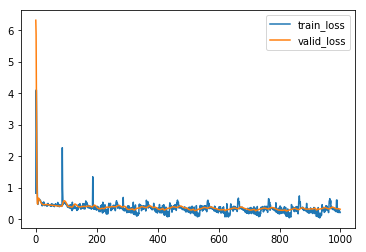

In [5]:
import matplotlib.pyplot as mplot

mplot.plot(train_loss, label='train_loss')
mplot.plot(valid_loss, label='valid_loss')
mplot.legend()
mplot.show()

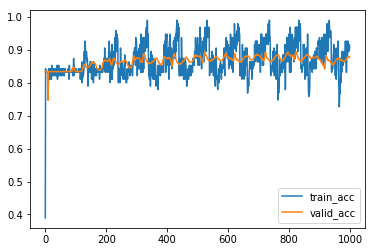

In [6]:
# import matplotlib.pyplot as mplot

mplot.plot(train_acc, label='train_acc')
mplot.plot(valid_acc, label='valid_acc')
mplot.legend()
mplot.show()